This notebook tries B-VAE from https://arxiv.org/pdf/1804.03599.pdf


## Notes

If it stalls around loss 60, you might need a smaller batch size, e.g. 8



## Log


In [1]:
import os
os.sys.path.append('.')

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from vae import VAE5, loss_function
from helpers.summarize import TorchSummarizeDf
from helpers.dataset import NumpyDataset, TQDMDaskProgressBar, load_npzs
from helpers.samplers import SequenceInChunkSampler
from rnn import MDNRNN

In [61]:
env_name='sonic256'

cuda= torch.cuda.is_available()

num_epochs=200
image_size=256
chunksize=1000
batch_size=16
action_dim = 12
seq_len = 1
gamma = 0.02
# data_cache_file = '/data/tmp/sonic_vae256.hdf5'
data_cache_file = '/MLDATA/sonic/sonic_rnn_256.hdf5'

# Load data

In [6]:
# load as dask array

filenames = sorted(glob.glob('/MLDATA/sonic/vae/obs_data_' + env_name + '_*.npz'))

if not os.path.isfile(data_cache_file):
    data_train = load_npzs(filenames)
    print(data_train)
    with TQDMDaskProgressBar():
        da.to_hdf5(data_cache_file, '/x', data_train)
       
    # clear mem
    del data_train 
    import gc
    gc.collect()
    
    # load as dask array

    filenames = sorted(glob.glob('/MLDATA/sonic/vae/action_data_' + env_name + '_*.npz'))
    data_train = load_npzs(filenames)
    print(data_train)
    with TQDMDaskProgressBar():
        da.to_hdf5(data_cache_file, '/y', data_train)

    # clear mem
    del data_train 
    import gc
    gc.collect()

In [7]:
# load
data = da.from_array(h5py.File(data_cache_file, mode='r')['x'], chunks=(chunksize, image_size, image_size, 3))
actions = da.from_array(h5py.File(data_cache_file, mode='r')['y'], chunks=(chunksize, action_dim))
data
data_split = int(len(data)*0.8)
data_train = data[:data_split]
data_test = data[data_split:]
actions_train = actions[:data_split]
actions_test = actions[data_split:]
data_train.shape, actions_train.shape, data_test.shape, actions_test.shape

((38400, 256, 256, 3), (38400, 12), (9600, 256, 256, 3), (9600, 12))

In [8]:

dataset_train = NumpyDataset(data_train, actions_train)
loader_train = torch.utils.data.DataLoader(
    dataset_train, 
    sampler=SequenceInChunkSampler(dataset_train, seq_len=seq_len, chunksize=chunksize),
    pin_memory=True, 
    shuffle=False, 
    batch_size=batch_size*seq_len, 
    drop_last=True
)


dataset_test = NumpyDataset(data_test, actions_test)
loader_test = torch.utils.data.DataLoader(
    dataset_test, 
    sampler=SequenceInChunkSampler(dataset_test, seq_len=seq_len, chunksize=chunksize),
    pin_memory=True, 
    shuffle=False, 
    batch_size=batch_size*seq_len, 
    drop_last=True
)

dataset_train, loader_train

(<helpers.dataset.NumpyDataset at 0x7fe078fe8c18>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe078fe8cf8>)

# View model

In [41]:

# vae = VAE5(image_size=image_size, z_dim=128*4, conv_dim=64, code_dim=2, k_dim=512)
# if cuda:
#     vae.cuda()
    
vae = VAE5(image_size=image_size, z_dim=128*2, conv_dim=48, code_dim=4, k_dim=256)
if cuda:
    vae.cuda()
    
# vae = VAE3(image_size=image_size, z_dim=8, conv_dim=64, code_dim=32, k_dim=512)
# if cuda:
#     vae.cuda()

In [42]:
16*3

48

In [43]:
# # Resume?
NAME='VAE5_3bigx256_256z_CVAE_nobottleneck_toosmall'
save_file = './models/{NAME}_state_dict.pkl'.format(NAME=NAME)
if os.path.isfile(save_file):
    state_dict = torch.load(save_file)
    vae.load_state_dict(state_dict)
    print('loaded {save_file}'.format(save_file=save_file))

In [44]:
img = np.random.randn(image_size, image_size, 3)
gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float()
if cuda:
    gpu_img = gpu_img.cuda()
with TorchSummarizeDf(vae) as tdf:
    x, mu, logvar = vae.forward(gpu_img)
    print(x.size())
    print(loss_function(x, gpu_img, mu, logvar))
    x = x.data.cpu().numpy()[0].transpose(1, 2, 0)
    df = tdf.make_df()
    
df[df.level<2]

torch.Size([1, 3, 256, 256])
(tensor(1.00000e+05 *
       [ 2.4576], device='cuda:0'), tensor([ 0.4182], device='cuda:0'))
Total parameters 11590819
Total trainable parameters 11590819


,name,class_name,input_shape,output_shape,nb_params,level
4,encoder.0,ConvBlock4,"[(-1, 3, 256, 256)]","[(-1, 48, 256, 256)]",1440,1
8,encoder.1,ConvBlock4,"[(-1, 48, 256, 256)]","[(-1, 96, 128, 128)]",74016,1
12,encoder.2,ConvBlock4,"[(-1, 96, 128, 128)]","[(-1, 144, 64, 64)]",221616,1
16,encoder.3,ConvBlock4,"[(-1, 144, 64, 64)]","[(-1, 192, 32, 32)]",442944,1
20,encoder.4,ConvBlock4,"[(-1, 192, 32, 32)]","[(-1, 240, 16, 16)]",738000,1
24,encoder.5,ConvBlock4,"[(-1, 240, 16, 16)]","[(-1, 288, 8, 8)]",1106784,1
28,encoder.6,ConvBlock4,"[(-1, 288, 8, 8)]","[(-1, 336, 4, 4)]",1549296,1
29,encoder.7,Conv2d,"[(-1, 336, 4, 4)]","[(-1, 256, 4, 4)]",86272,1
30,mu,Linear,"[(-1, 4096)]","[(-1, 256)]",1048832,0
31,logvar,Linear,"[(-1, 4096)]","[(-1, 256)]",1048832,0


## Train

In [62]:
# def loss_function(recon_x, x, mu, logvar):
#     # Reconstruction + KL divergence losses summed over all elements and batch
#     # https://github.com/pytorch/examples/blob/master/vae/main.py
#     n, c, h, w = recon_x.size()
    
#     recon_x = recon_x.view(n, -1)
#     x = x.view(n, -1)
    
#     # L2 distance
#     loss_recon = torch.sum(torch.pow(recon_x - x, 2), 1)
    
#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1)
#     return loss_recon, loss_KLD

In [63]:
import collections

def train(loader, net, optimizer, loss_function, test=False, cuda=True, max_batches=None):
    if test:
        net.eval()
    else:
        net.train()
        
    if max_batches is None:
        max_batches = len(loader)
    else:
        max_batches = min(max_batches, len(loader))
    iterator = iter(loader)
        
    info = collections.defaultdict(list)
    
    with tqdm(total=max_batches*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i in range(max_batches):
            batch, _ = next(iterator)
            x = Variable(batch.transpose(1,3))
            if cuda:
                x=x.cuda()
            y, mu, logvar = vae.forward(x)
            loss_recon, loss_KLD = loss_function(y, x, mu, logvar)
            loss = loss_recon + gamma * torch.abs(loss_KLD-C)
            loss = loss.mean() # mean along the batches
            
            info['loss'].append(loss.cpu().data.item())
            info['loss_recon'].append(loss_recon.mean().cpu().data.item())
            info['loss_KLD'].append(loss_KLD.mean().cpu().data.item())
            
            if not test:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            prog.update(loader.batch_size)
            prog.desc='loss={loss:2.2f} [ {loss_recon:2.2f} + {rhs:2.2f}={loss_recon:2.2f} + {gamma}*|{loss_KLD:2.2f} - {C}| ]'.format(
                loss=np.mean(info['loss']),
                loss_recon=np.mean(info['loss_recon']),
                gamma=gamma,
                C=C,
                loss_KLD=np.mean(info['loss_KLD']),
                rhs = gamma*np.abs(np.mean(info['loss_KLD'])-C)
            )
            if i==100:
                print(prog.desc)
        print(prog.desc)
        prog.close()
    return info

In [64]:
# Plot reconstructions
def plot_results(loader=loader_test, n=2, epoch=0):
    x,_ = next(iter(loader))

    X = Variable(x).transpose(1,3).contiguous()
    if cuda:
        X = X.cuda()
    Y, mu, logvar = vae.forward(X)
    loss_recon, loss_KLD = loss_function(Y, X, mu, logvar)
    loss = loss_recon + gamma * torch.abs(loss_KLD-C)

    y=Y.cpu().data.transpose(1,3).numpy()
    for i in range(n):
        plt.figure(figsize=(6,3))
        plt.subplot(1, 2, 1)
        plt.title('original')
        plt.axis('off')
        plt.imshow(x[i].numpy())

        plt.subplot(1, 2, 2)
        plt.imshow(y[i])
        plt.axis('off')
        plt.title('reconstructed')

        plt.suptitle('epoch {}, index {}, loss {:2.4f}'.format(epoch, i, loss[i].cpu().data.numpy()))
        plt.show()
        
    del y
    del Y
    del X
    del x
    del mu
    del logvar
    del loss
        
# plot_results(loader=loader_test, n=2, epoch=epoch)

In [48]:
# Train
optimizer = optim.Adam(vae.parameters(), lr=3e-5)
import torch.optim.lr_scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

In [49]:
histories=[]
C = 0
C_epoch_inc = 10 # How much to increase C by each epoch
max_batches=40000//loader_train.batch_size

In [ ]:
for epoch in range(num_epochs): 
    # Train/test
    info = train(loader_train, vae, optimizer, loss_function, test=False, cuda=True, max_batches=max_batches)
    torch.cuda.empty_cache()
    info_val = train(loader_test, vae, optimizer, loss_function, test=True, cuda=True, max_batches=max_batches//4)
    
    # Adjust
    scheduler.step(np.mean(info_val['loss']))
    C += C_epoch_inc
    
    # Record
    history = {k+'_val':np.mean(v) for k,v in info_val.items()}
    history.update({k:np.mean(v) for k,v in info.items()})
    histories.append(history)
    torch.save(vae.state_dict(), './models/{NAME}_{epoch}_state_dict.pkl'.format(NAME=NAME, epoch=epoch))
    
    # View    
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f}'.format(epoch, np.mean(info['loss']), np.mean(info_val['loss'])))
    plot_results(loader=loader_test, n=4, epoch=epoch)
    torch.cuda.empty_cache()


/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


loss=3535.64 [ 3530.90 + 4.74=3530.90 + 0.02*|456.94 - 220| ]


.

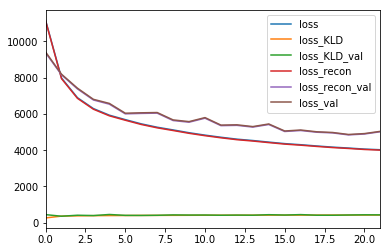

In [51]:
# plot history
import pandas as pd
histories = pd.DataFrame(histories)
histories.plot()

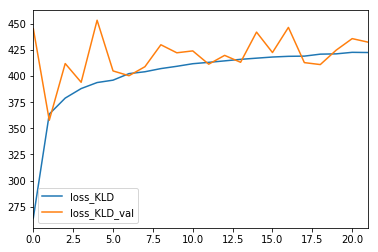

In [60]:
histories[['loss_KLD','loss_KLD_val']].plot()

In [59]:
histories

,loss,loss_KLD,loss_KLD_val,loss_recon,loss_recon_val,loss_val
0,11164.169295,264.197479,445.359502,11137.749556,9369.277379,9413.813292
1,7979.276516,363.636192,357.658458,7943.912883,8153.239229,8188.005135
2,6893.067559,378.926980,412.009221,6857.174868,7378.061401,7417.262323
3,6293.465367,388.045817,394.066627,6257.660790,6766.875101,6803.281736
4,5929.414861,393.811763,453.472268,5894.033690,6536.589797,6577.937056
5,5684.523420,396.105147,404.937619,5649.912931,6002.269532,6037.763351
6,5450.944732,402.363755,400.357474,5416.708359,6026.516433,6060.552160
7,5265.205771,404.156442,408.977310,5231.790130,6041.187463,6075.085186
8,5116.028734,407.180119,429.993696,5083.310729,5632.822246,5667.821611
9,4960.941759,409.371541,422.315543,4929.004602,5541.388293,5574.619847


In [56]:
torch.save(vae.state_dict(), './models/{NAME}_state_dict.pkl'.format(NAME=NAME))
torch.save(vae, './models/{NAME}.pkl'.format(NAME=NAME))
'./models/{NAME}_state_dict.pkl'.format(NAME=NAME)

'./models/VAE5_3bigx256_256z_CVAE_nobottleneck_toosmall_state_dict.pkl'

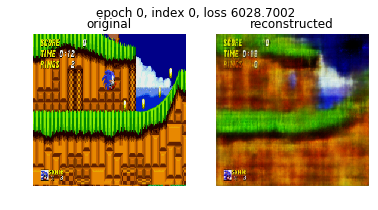

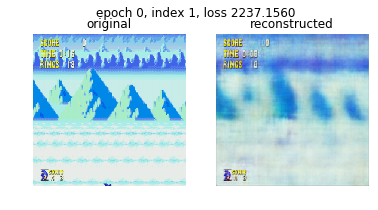

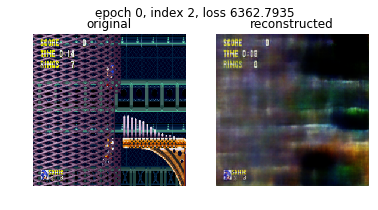

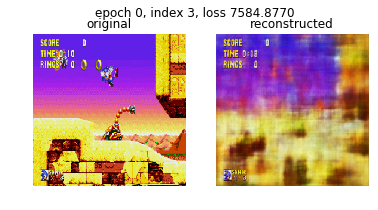

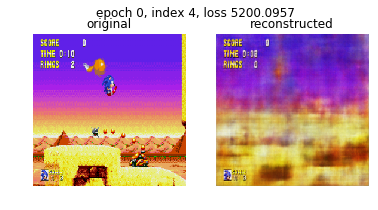

In [57]:
plot_results(loader=loader_test, n=5, epoch=0)
torch.cuda.empty_cache()

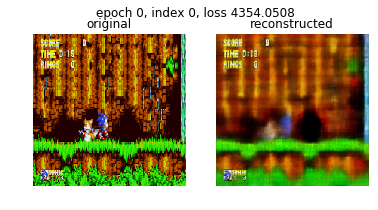

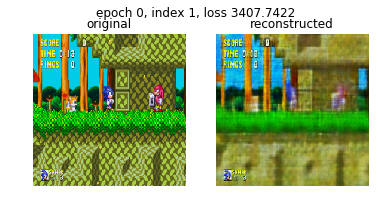

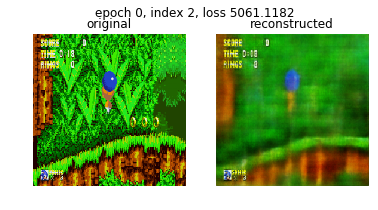

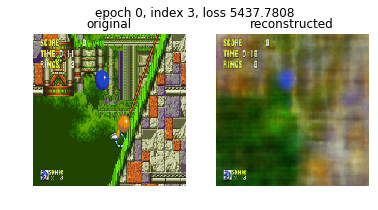

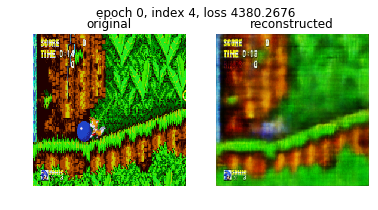

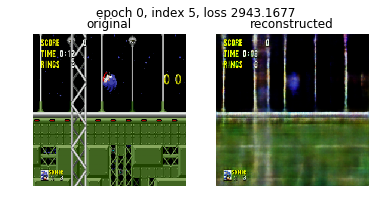

In [58]:
plot_results(loader=loader_train, n=6, epoch=0)
torch.cuda.empty_cache()

# End

In [ ]:
%time x=data_test[500]

In [ ]:
# DEBUG check chunk size
# should be less than 1e9
# should take more than 100ms, less than 1s
import itertools
x=data_train
shapes = list(itertools.product(*x.chunks))
nbytes = [x.dtype.itemsize * np.prod(shape) for shape in shapes]
assert nbytes[0]<1e9
nbytes[0]